In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Installing the packages

!pip install tensorflow-io
!pip install kafka-python

In [ ]:
# Importing the packages

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
import time 
from kafka import KafkaProducer
import tensorflow as tf
import tensorflow_io as tfio
# import pickle as pkl
from joblib import load

Download and setup Kafka for real time data stream simulation. 


In [ ]:
!curl -sSOL https://downloads.apache.org/kafka/2.8.1/kafka_2.12-2.8.1.tgz
!tar -xzf kafka_2.12-2.8.1.tgz 

Start Kafka and Zookeeper servers as a daemon processes. Zookeeper is a centralized service for maintaing configuration information, naming, providing distributed synchronization, and providing group services.

In [ ]:
!./kafka_2.12-2.8.1/bin/zookeeper-server-start.sh -daemon ./kafka_2.12-2.8.1/config/zookeeper.properties
!./kafka_2.12-2.8.1/bin/kafka-server-start.sh -daemon ./kafka_2.12-2.8.1/config/server.properties

### Create a topic to store partitions
Create topic for train and test dataset to store events in Kafka. Kafka is a distributed event streaming platform that lets you read, write, store and process partitions. These events or messages are organized and stored in topics. In simple terms, topic is similar to a folder in a filesystem, and the message are the file in that folder.

In [ ]:
!./kafka_2.12-2.8.1/bin/kafka-topics.sh --create --topic home-train --bootstrap-server localhost:9092 --replication-factor 1 --partitions 1
!./kafka_2.12-2.8.1/bin/kafka-topics.sh --create --topic home-test --bootstrap-server localhost:9092 --replication-factor 1 --partitions 2

Error while executing topic command : Topic 'home-train' already exists.
[2021-12-09 17:04:16,907] ERROR org.apache.kafka.common.errors.TopicExistsException: Topic 'home-train' already exists.
 (kafka.admin.TopicCommand$)
Error while executing topic command : Topic 'home-test' already exists.
[2021-12-09 17:04:20,213] ERROR org.apache.kafka.common.errors.TopicExistsException: Topic 'home-test' already exists.
 (kafka.admin.TopicCommand$)


### Describe the topic for details
Describe command helps us gather details on topic, it's partitions, replicas, and other important information.


In [ ]:
!./kafka_2.12-2.8.1/bin/kafka-topics.sh --describe --topic home-train --bootstrap-server localhost:9092
!./kafka_2.12-2.8.1/bin/kafka-topics.sh --describe --topic home-test --bootstrap-server localhost:9092

Topic: home-train	TopicId: 3wH1pcJbSpScV85RQ2OlZg	PartitionCount: 1	ReplicationFactor: 1	Configs: segment.bytes=1073741824
	Topic: home-train	Partition: 0	Leader: 0	Replicas: 0	Isr: 0
Topic: home-test	TopicId: xCbuluo9Sh6Wa06eOUAqgQ	PartitionCount: 2	ReplicationFactor: 1	Configs: segment.bytes=1073741824
	Topic: home-test	Partition: 0	Leader: 0	Replicas: 0	Isr: 0
	Topic: home-test	Partition: 1	Leader: 0	Replicas: 0	Isr: 0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Software Engg Regression Analysis/[LATEST] Manish New Data/onlineLearningData.csv")

In [ ]:
data.head(10)

,city,state,street,streetSuffix,zip,latitude,longitude,landUseDescription,zoningDescription,lotSizeAcres,lotSizeSquareFeet,lotTopography,condition,architecturalStyle,yearBuilt,totalStories,totalRooms,bedrooms,baths,heating,airConditioning,foundation,fireplace,soldYear,housePrice
0,0.55,0.183673,0.732941,0.738462,-0.427423,0.073222,-0.111884,0.8125,0.494253,-0.042721,-0.042721,0.2,0,0.8,-1.133603,-1.107410,0.325799,-0.689433,-1.007367,0.25,1,0,0,0,179300
1,0.55,0.183673,0.640179,0.569231,-0.427423,-10.080057,10.082796,0.8125,0.494253,-0.006182,-0.006182,0.2,0,0.4,-1.207690,0.876433,-0.742079,-0.689433,0.156434,0.25,1,1,0,0,210500
2,0.55,0.183673,0.489318,0.215385,-0.427423,0.074465,-0.112542,0.1875,0.482759,-0.015317,-0.015316,0.2,0,0.2,-1.207690,0.876433,0.325799,0.573313,0.156434,0.25,1,1,0,0,251400
3,0.55,0.183673,0.211031,0.646154,-0.427423,0.073769,-0.112294,0.8125,0.494253,-0.033586,-0.033586,0.2,0,1.0,-1.207690,-1.107410,-0.742079,-0.689433,-1.007367,0.25,1,1,0,0,215400
4,0.55,0.183673,0.198060,0.646154,-0.427423,0.073605,-0.112189,0.8125,0.482759,0.094302,0.094302,0.2,0,0.6,-0.763171,-1.107410,-0.742079,-0.689433,-1.007367,0.25,1,0,0,0,191800
5,0.55,0.183673,0.198060,0.646154,-0.427423,0.073765,-0.112220,0.8125,0.482759,-0.079261,-0.079260,0.0,0,0.4,-1.207690,0.876433,0.325799,0.573313,0.156434,0.25,1,1,0,0,200000
6,0.55,0.183673,0.020929,0.246154,-0.427423,0.075691,-0.111749,0.1875,0.482759,-0.051856,-0.051856,0.0,0,0.2,-0.614999,0.876433,0.325799,0.573313,0.156434,0.25,1,0,0,0,272600
7,0.55,0.183673,0.679638,0.246154,-0.427423,0.075310,-0.112056,0.1875,0.482759,0.012088,0.012088,0.0,0,0.2,-0.689085,-1.107410,-0.208140,0.573313,0.156434,0.25,1,1,0,0,254000
8,0.55,0.183673,0.679638,0.246154,-0.427423,0.074490,-0.111933,0.1875,0.482759,0.030358,0.030358,0.0,0,0.2,-0.689085,0.876433,0.859737,0.573313,0.156434,0.25,1,0,0,0,247700
9,0.55,0.183673,0.103990,0.246154,-0.427423,0.075564,-0.111954,0.1875,0.482759,0.231325,0.231325,0.4,0,0.2,-0.170480,0.876433,0.325799,0.573313,0.156434,0.25,1,1,0,0,269900


In [ ]:
train_df, test_df = train_test_split(data, test_size=0.3, shuffle=True)
test_df, validate_df = train_test_split(test_df, test_size= 0.3, shuffle= True)
x_train_df = train_df.drop(["housePrice"], axis=1)
y_train_df = train_df["housePrice"]

x_test_df = test_df.drop(["housePrice"], axis=1)
y_test_df = test_df["housePrice"]

x_validate_df = validate_df.drop(["housePrice"], axis = 1)
y_validate_df = validate_df["housePrice"]

In [ ]:
print("Number of training samples: ",len(train_df))
print("Number of testing sample: ",len(test_df))

Number of training samples:  35
Number of testing sample:  10


### Convert data to list format
Read each row from the dataframe and convert it to the list format to feed to Kafka.

In [ ]:
#Convert each test and train dataframe to list form to feed to kafka
x_train = list(filter(None, x_train_df.to_csv(index=False).split("\n")[1:]))
y_train = list(filter(None, y_train_df.to_csv(index=False).split("\n")[1:]))

x_test = list(filter(None, x_test_df.to_csv(index=False).split("\n")[1:]))
y_test = list(filter(None, y_test_df.to_csv(index=False).split("\n")[1:]))
len(x_train), len(y_train), len(x_test), len(y_test)

(35, 35, 10, 10)

In [ ]:
NUM_COLUMNS = len(x_train_df.columns)

### Create Kafka Producer 
Create Kafka producer which takes in data and sends the record to the partition within a topic in Kafka cluster. 

In [ ]:
#send each record to a partition within a topic in kafka cluster
def write_to_kafka(topic, items):
  count=0
  producer = KafkaProducer(bootstrap_servers=['localhost:9092'])
  for message, key in items:
    producer.send(topic, key=key.encode('utf-8'), value=message.encode('utf-8'))
    count += 1 
  producer.flush()
  print("Wrote {0} messages into topic: {1}".format(count, topic))

write_to_kafka("home-train", zip(x_train, y_train))
write_to_kafka("home-test", zip(x_test, y_test))

Wrote 35 messages into topic: home-train
Wrote 10 messages into topic: home-test


### Online Learning
Unlike traditional training of machine learning models, online learning is based on incrementally learning or updating parameters as soon as the new data points are available. This process continues indefinitely. In the code below, stream_timeout is set to 10000 milliseconds which means as all the messages are consumed from the topic, the dataset will wait for 10 more seconds before timing out and disconnecting from the Kafka cluster. If additional data arrives in that time period, model training resumes. 

In [ ]:
online_train_ds = tfio.experimental.streaming.KafkaGroupIODataset(
    topics=["home-train"],
    group_id="cgonline",
    servers="localhost:9092",
    stream_timeout=10000, # in milliseconds, to block indefinitely, set it to -1.
    configuration=[
        "session.timeout.ms=7000",
        "max.poll.interval.ms=8000",
        "auto.offset.reset=earliest"
    ],
)

def decode_kafka_online_item(raw_message, raw_key):
  message = tf.io.decode_csv(raw_message, [[0.0] for i in range(NUM_COLUMNS)])
  key = tf.strings.to_number(raw_key)
  return (message, key)

In [ ]:
# We decode the data and their corresponding labels, and store them as a simple array

online_train_ds_temp = online_train_ds.map(decode_kafka_online_item)

final_online_data = list()
final_online_label = list()

for data, label in online_train_ds_temp:
  data = np.array(data)
  label = np.array(label)
  final_online_data.append(data)
  final_online_label.append(label)

In [ ]:
final_online_data[:5]

[array([ 0.5       ,  0.18367347,  0.44190103,  0.21538462, -0.4460443 ,
         0.08095665, -0.10649131,  0.8125    ,  0.9770115 , -0.2802274 ,
        -0.28022727,  0.        ,  0.        ,  0.4       ,  0.5703841 ,
         0.87643266, -1.2760178 , -0.6894334 ,  0.15643424,  0.25      ,
         1.        ,  1.        ,  0.        ,  0.        ], dtype=float32),
 array([ 0.55      ,  0.18367347,  0.6950076 ,  0.24615385, -0.42742252,
         0.06264027, -0.10681795,  0.8125    ,  0.49425286,  1.5832833 ,
         1.5832833 ,  0.2       ,  0.        ,  1.        , -1.6522083 ,
        -1.1074098 , -0.74207896, -0.6894334 , -1.0073668 ,  0.25      ,
         1.        ,  1.        ,  0.        ,  0.        ], dtype=float32),
 array([ 0.5       ,  0.18367347,  0.8446697 ,  0.24615385, -0.4460443 ,
         0.08162275, -0.10560156,  0.8125    ,  0.6666667 , -0.17974396,
        -0.17974387,  0.2       ,  0.        ,  0.4       ,  0.19995204,
         0.87643266,  0.32579863, -0.689433

In [ ]:
final_online_label[:5]

[array(241100., dtype=float32),
 array(292000., dtype=float32),
 array(204600., dtype=float32),
 array(218100., dtype=float32),
 array(200000., dtype=float32)]

In [ ]:
# Loading the pretrained random forest model

import joblib

rf_model = joblib.load("/content/drive/MyDrive/Software Engg Regression Analysis/[LATEST] Manish New Data/final_rf_model.joblib")

In [ ]:
type(rf_model)

sklearn.ensemble._forest.RandomForestRegressor

In [ ]:
# Fitting the pretrained random forest model using the online data

rf_model.fit(final_online_data, final_online_label)

RandomForestRegressor(max_depth=23)

In [ ]:
# Now testing the new model predictions on the new online data

preds = rf_model.predict(final_online_data)

In [ ]:
from sklearn.metrics import r2_score

print(f"R2-Score: {round(r2_score(final_online_label, preds), 3)}")

R2-Score: 0.891


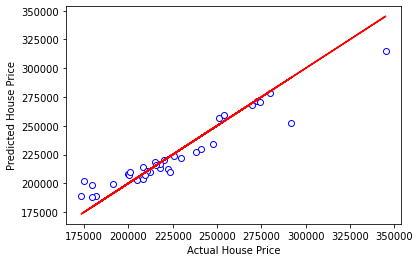

In [ ]:
# Plotting the predictions on new online data

plt.scatter(final_online_label, preds, c='w', edgecolors='b')
plt.plot(final_online_label, final_online_label, c='r')
plt.xlabel(f"Actual House Price")
plt.ylabel(f"Predicted House Price")
plt.savefig("Validation Regression Calibration Plot.png", dpi=300)
plt.show()